In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import pmdarima as pm
import warnings 

from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


warnings.filterwarnings("ignore") 

%matplotlib inline

# Data

In [2]:
hourly_mean = pd.read_csv('../../data/Fernando/hourly_mean.csv')
df_train = pd.read_csv('../../data/Fernando/df_train.csv')
hourly_mean_log = pd.read_csv('../../data/Fernando/hourly_mean_log.csv')
df_test = pd.read_csv('../../data/ElectricDemandForecasting-DL-master_data_CECOVEL_test.csv')
hourly_mean_return_log = pd.read_csv('../../data/Fernando/hourly_mean_return_log.csv')

In [3]:
hourly_mean_return_log.head()

,datetime,Valor,Dia,Ano,Hora,Minuto,return-log
0,2015-03-02 00:00:00,1.000,2.0,2015.0,0.0,0.0,0.000346
1,2015-03-02 01:00:00,32.565,2.0,2015.0,1.0,0.0,3.483238
2,2015-03-02 02:00:00,38.347,2.0,2015.0,2.0,0.0,0.163438
3,2015-03-02 03:00:00,26.616,2.0,2015.0,3.0,0.0,-0.365164
4,2015-03-02 04:00:00,17.202,2.0,2015.0,4.0,0.0,-0.436487


In [4]:
hourly_mean_return_log['datetime'] = pd.to_datetime(hourly_mean_return_log['datetime'])
hourly_mean_log['datetime'] = pd.to_datetime(hourly_mean_log['datetime'])
hourly_mean['datetime'] = pd.to_datetime(hourly_mean['datetime'])

In [5]:
type(hourly_mean_return_log.iloc[0]['datetime'])

pandas._libs.tslibs.timestamps.Timestamp

In [6]:
hourly_mean.head()

,datetime,Valor,Dia,Ano,Hora,Minuto
0,2015-03-02 00:00:00,1.000,2.0,2015.0,0.0,0.0
1,2015-03-02 01:00:00,32.565,2.0,2015.0,1.0,0.0
2,2015-03-02 02:00:00,38.347,2.0,2015.0,2.0,0.0
3,2015-03-02 03:00:00,26.616,2.0,2015.0,3.0,0.0
4,2015-03-02 04:00:00,17.202,2.0,2015.0,4.0,0.0


In [7]:
hourly_mean_log.head()

,datetime,Valor
0,2015-03-02 00:00:00,0.000000
1,2015-03-02 01:00:00,3.483238
2,2015-03-02 02:00:00,3.646676
3,2015-03-02 03:00:00,3.281513
4,2015-03-02 04:00:00,2.845026


In [8]:
hourly_mean.set_index('datetime',inplace=True)
hourly_mean.head()

,Valor,Dia,Ano,Hora,Minuto
datetime,,,,,
2015-03-02 00:00:00,1.000,2.0,2015.0,0.0,0.0
2015-03-02 01:00:00,32.565,2.0,2015.0,1.0,0.0
2015-03-02 02:00:00,38.347,2.0,2015.0,2.0,0.0
2015-03-02 03:00:00,26.616,2.0,2015.0,3.0,0.0
2015-03-02 04:00:00,17.202,2.0,2015.0,4.0,0.0


In [9]:
hourly_mean_log.set_index('datetime',inplace=True)
hourly_mean_log.head()

,Valor
datetime,
2015-03-02 00:00:00,0.000000
2015-03-02 01:00:00,3.483238
2015-03-02 02:00:00,3.646676
2015-03-02 03:00:00,3.281513
2015-03-02 04:00:00,2.845026


In [10]:
hourly_mean_return_log.set_index('datetime',inplace=True)
hourly_mean_return_log.head()

,Valor,Dia,Ano,Hora,Minuto,return-log
datetime,,,,,,
2015-03-02 00:00:00,1.000,2.0,2015.0,0.0,0.0,0.000346
2015-03-02 01:00:00,32.565,2.0,2015.0,1.0,0.0,3.483238
2015-03-02 02:00:00,38.347,2.0,2015.0,2.0,0.0,0.163438
2015-03-02 03:00:00,26.616,2.0,2015.0,3.0,0.0,-0.365164
2015-03-02 04:00:00,17.202,2.0,2015.0,4.0,0.0,-0.436487


In [11]:
df_test.head()

,value,timestamp
0,27.298,2016-03-01T00:00
1,176.818,2016-03-01T01:00
2,137.341,2016-03-01T02:00
3,116.532,2016-03-01T03:00
4,84.029,2016-03-01T04:00


In [12]:
df_test.columns = ['Valor', 'timestamp']

In [13]:
df_test.head()

,Valor,timestamp
0,27.298,2016-03-01T00:00
1,176.818,2016-03-01T01:00
2,137.341,2016-03-01T02:00
3,116.532,2016-03-01T03:00
4,84.029,2016-03-01T04:00


In [14]:
df_test.to_csv('../../data/Fernando/df_test.csv')

# Fazendo hourly_mean, log_data e return_log_data do dataframe de teste

In [15]:
from datetime import datetime
df_test["datetime"] = df_test["timestamp"].apply(lambda x : datetime.strptime(x,'%Y-%m-%dT%H:%M'))

In [16]:
df_test.head()

,Valor,timestamp,datetime
0,27.298,2016-03-01T00:00,2016-03-01 00:00:00
1,176.818,2016-03-01T01:00,2016-03-01 01:00:00
2,137.341,2016-03-01T02:00,2016-03-01 02:00:00
3,116.532,2016-03-01T03:00,2016-03-01 03:00:00
4,84.029,2016-03-01T04:00,2016-03-01 04:00:00


In [17]:
df_test_without_zeroes = df_test.drop( df_test[ df_test['Valor'] == 0 ].index )

In [18]:
df_test_without_zeroes.isnull().sum()

Valor        0
timestamp    0
datetime     0
dtype: int64

In [19]:
hourly_mean_test = df_test_without_zeroes.set_index('datetime').resample('H').mean()

In [20]:
hourly_mean_test.isnull().sum()

Valor    2
dtype: int64

In [21]:
for col in hourly_mean_test.columns:
    hourly_mean_test[col] = hourly_mean_test.fillna(hourly_mean_test[col].mean())

In [22]:
hourly_mean_test.isnull().sum()

Valor    0
dtype: int64

In [23]:
hourly_mean_test.head()

,Valor
datetime,
2016-03-01 00:00:00,27.298
2016-03-01 01:00:00,176.818
2016-03-01 02:00:00,137.341
2016-03-01 03:00:00,116.532
2016-03-01 04:00:00,84.029


In [24]:
hourly_mean_test.to_csv('../../data/Fernando/hourly_mean_test.csv')

In [25]:
# a transformação log
hourly_mean_log_test = np.log(hourly_mean_test['Valor']).to_frame()

In [26]:
hourly_mean_log_test.isnull().sum()

Valor    0
dtype: int64

In [27]:
hourly_mean_log_test.to_csv('../../data/Fernando/hourly_mean_log_test.csv')

In [28]:
# a transformação return log
hourly_mean_return_log_test = hourly_mean_test.copy()
hourly_mean_return_log_test['return-log'] = np.log(hourly_mean_return_log_test['Valor']) - np.log(hourly_mean_return_log_test['Valor'].shift(1))

In [29]:
hourly_mean_return_log_test.isnull().sum()

Valor         0
return-log    1
dtype: int64

In [30]:
for col in hourly_mean_return_log_test.columns:
    hourly_mean_return_log_test[col] = hourly_mean_return_log_test[col].fillna(hourly_mean_return_log_test[col].mean())

In [31]:
hourly_mean_return_log_test.isnull().sum()

Valor         0
return-log    0
dtype: int64

In [32]:
hourly_mean_return_log_test.to_csv('../../data/Fernando/hourly_mean_return_log_test.csv')

In [33]:
hourly_mean.drop(['Dia','Ano','Hora','Minuto'], axis = 1, inplace=True)

In [34]:
hourly_mean.head()

,Valor
datetime,
2015-03-02 00:00:00,1.000
2015-03-02 01:00:00,32.565
2015-03-02 02:00:00,38.347
2015-03-02 03:00:00,26.616
2015-03-02 04:00:00,17.202


In [35]:
hourly_mean.reset_index(inplace=True)
hourly_mean_test.reset_index(inplace=True)
hourly_mean_log.reset_index(inplace=True)
hourly_mean_log_test.reset_index(inplace=True)
hourly_mean_return_log.reset_index(inplace=True)
hourly_mean_return_log_test.reset_index(inplace=True)

In [36]:
hourly_mean.head()

,datetime,Valor
0,2015-03-02 00:00:00,1.000
1,2015-03-02 01:00:00,32.565
2,2015-03-02 02:00:00,38.347
3,2015-03-02 03:00:00,26.616
4,2015-03-02 04:00:00,17.202


In [37]:
hourly_mean_test.head()

,datetime,Valor
0,2016-03-01 00:00:00,27.298
1,2016-03-01 01:00:00,176.818
2,2016-03-01 02:00:00,137.341
3,2016-03-01 03:00:00,116.532
4,2016-03-01 04:00:00,84.029


In [38]:
hourly_mean_log.head()

,datetime,Valor
0,2015-03-02 00:00:00,0.000000
1,2015-03-02 01:00:00,3.483238
2,2015-03-02 02:00:00,3.646676
3,2015-03-02 03:00:00,3.281513
4,2015-03-02 04:00:00,2.845026


In [39]:
hourly_mean_log_test.head()

,datetime,Valor
0,2016-03-01 00:00:00,3.306813
1,2016-03-01 01:00:00,5.175121
2,2016-03-01 02:00:00,4.922467
3,2016-03-01 03:00:00,4.758166
4,2016-03-01 04:00:00,4.431162


In [40]:
hourly_mean_return_log_test.head()

,datetime,Valor,return-log
0,2016-03-01 00:00:00,27.298,-0.000044
1,2016-03-01 01:00:00,176.818,1.868308
2,2016-03-01 02:00:00,137.341,-0.252654
3,2016-03-01 03:00:00,116.532,-0.164301
4,2016-03-01 04:00:00,84.029,-0.327004


In [41]:
hourly_mean_return_log.head()

,datetime,Valor,Dia,Ano,Hora,Minuto,return-log
0,2015-03-02 00:00:00,1.000,2.0,2015.0,0.0,0.0,0.000346
1,2015-03-02 01:00:00,32.565,2.0,2015.0,1.0,0.0,3.483238
2,2015-03-02 02:00:00,38.347,2.0,2015.0,2.0,0.0,0.163438
3,2015-03-02 03:00:00,26.616,2.0,2015.0,3.0,0.0,-0.365164
4,2015-03-02 04:00:00,17.202,2.0,2015.0,4.0,0.0,-0.436487


##### OBS: Todas as observações são avaliações por hora.

# Modelo Trivial ou de Persistência

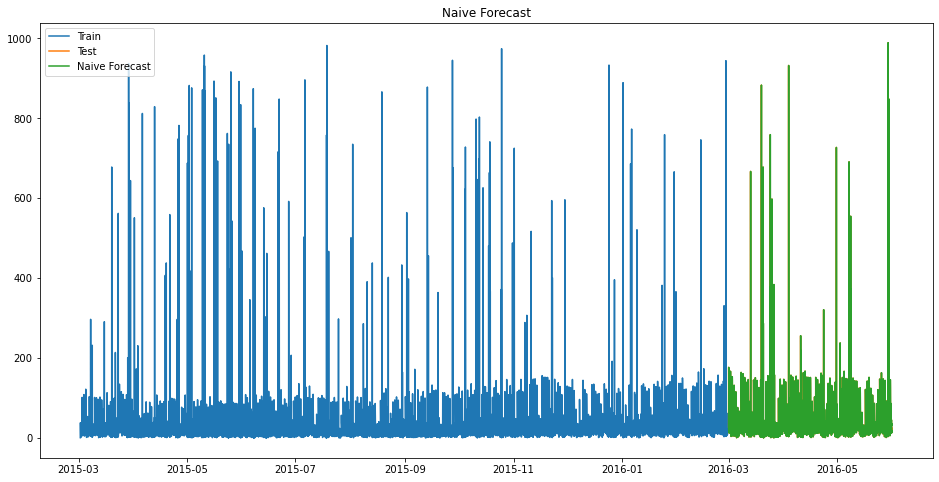

In [42]:
actual_values = hourly_mean_test['Valor']
df_train_history = [x for x in hourly_mean['Valor']]
predictions = list()
for i in range(len(actual_values)):
    predictions.append(df_train_history[-1])
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean['datetime'], hourly_mean['Valor'], label='Train')
plt.plot(hourly_mean_test['datetime'],hourly_mean_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

84.80116636250233


## Agora com a base transformada(log)

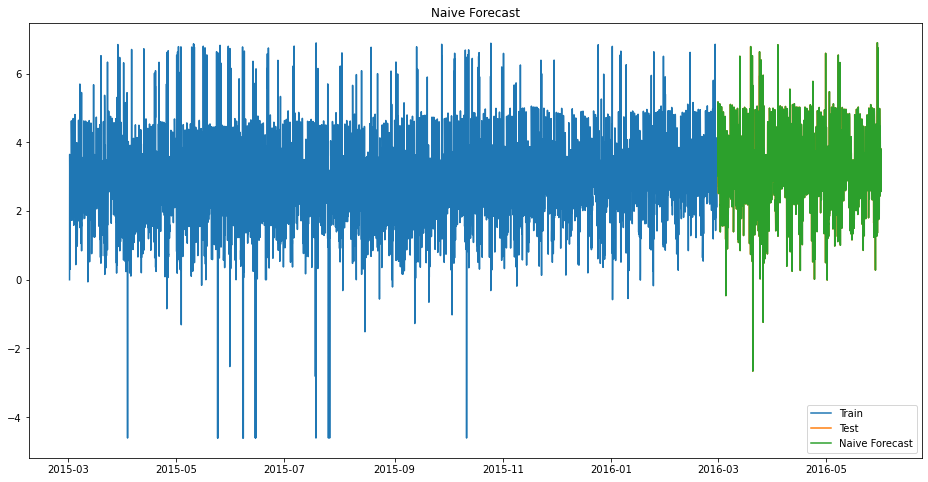

In [44]:
actual_values = hourly_mean_log_test['Valor']
df_train_history = [x for x in hourly_mean_log['Valor']]
predictions = list()
for i in range(len(actual_values)):
    predictions.append(df_train_history[-1])
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_log_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean_log['datetime'], hourly_mean_log['Valor'], label='Train')
plt.plot(hourly_mean_log_test['datetime'],hourly_mean_log_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

74.07662911954316


## Agora com a base transformada (return log)

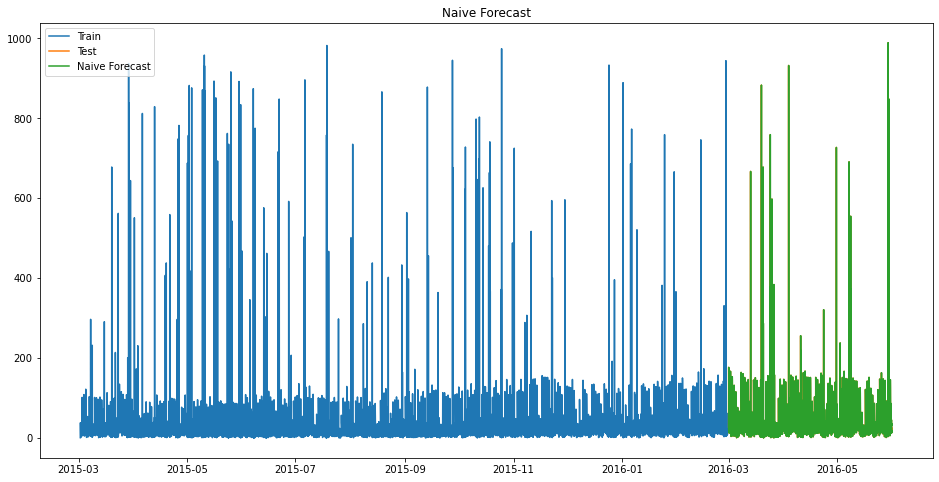

In [46]:
actual_values = hourly_mean_return_log_test['Valor']
df_train_history = [x for x in hourly_mean_return_log['Valor']]
predictions = list()
for i in range(len(actual_values)):
    predictions.append(df_train_history[-1])
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_return_log_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean_return_log['datetime'], hourly_mean_return_log['Valor'], label='Train')
plt.plot(hourly_mean_return_log_test['datetime'],hourly_mean_return_log_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

84.80116636250233


# Modelo de Alisamento Exponencial

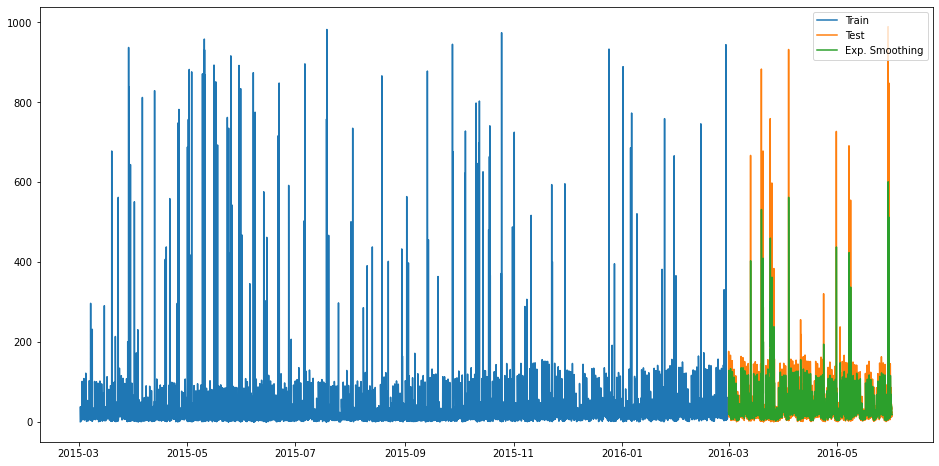

In [48]:
actual_values = hourly_mean_test['Valor']
df_train_history = [x for x in hourly_mean['Valor']]
predictions = list()
alpha = 1
for i in range(len(actual_values)):
    model_fit = SimpleExpSmoothing(df_train_history).fit(smoothing_level=0.6,optimized=False)
    predictions.append(model_fit.predict(len(df_train_history),len(df_train_history)))
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean['datetime'], hourly_mean['Valor'], label='Train')
plt.plot(hourly_mean_test['datetime'],hourly_mean_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Exp. Smoothing')
plt.legend(loc='best')
plt.show()

In [49]:
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

73.27501324441924


## Agora com a base transformada (log)

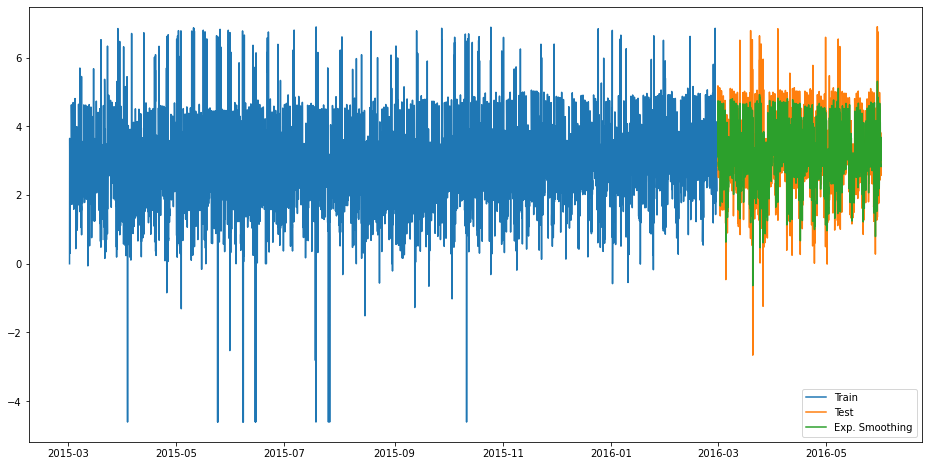

In [50]:
actual_values = hourly_mean_log_test['Valor']
df_train_history = [x for x in hourly_mean_log['Valor']]
predictions = list()
alpha = 1
for i in range(len(actual_values)):
    model_fit = SimpleExpSmoothing(df_train_history).fit(smoothing_level=0.6,optimized=False)
    predictions.append(model_fit.predict(len(df_train_history),len(df_train_history)))
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_log_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean_log['datetime'], hourly_mean_log['Valor'], label='Train')
plt.plot(hourly_mean_log_test['datetime'],hourly_mean_log_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Exp. Smoothing')
plt.legend(loc='best')
plt.show()

In [51]:
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

74.12264835879257


## Agora com a base transformada (return log)

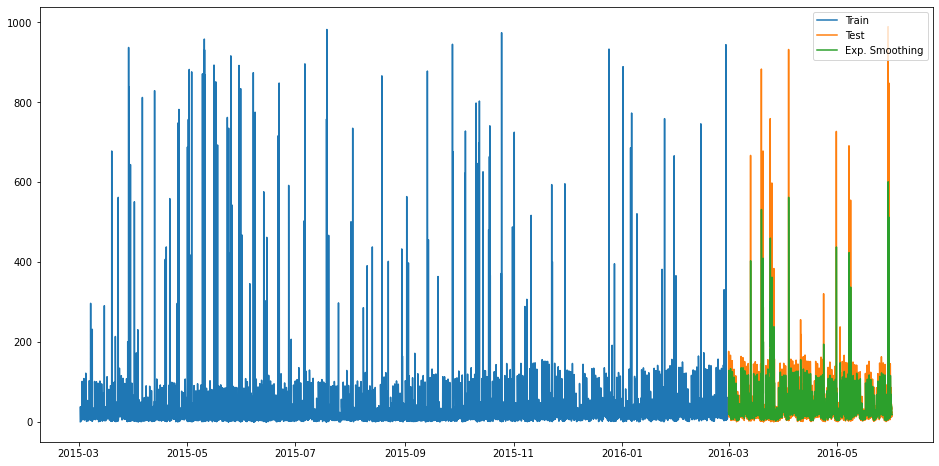

In [52]:
actual_values = hourly_mean_return_log_test['Valor']
df_train_history = [x for x in hourly_mean_return_log['Valor']]
predictions = list()
alpha = 1
for i in range(len(actual_values)):
    model_fit = SimpleExpSmoothing(df_train_history).fit(smoothing_level=0.6,optimized=False)
    predictions.append(model_fit.predict(len(df_train_history),len(df_train_history)))
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_return_log_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean_return_log['datetime'], hourly_mean_return_log['Valor'], label='Train')
plt.plot(hourly_mean_return_log_test['datetime'],hourly_mean_return_log_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Exp. Smoothing')
plt.legend(loc='best')
plt.show()

In [53]:
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

73.27501324441924


# Modelo de Holt-Winters

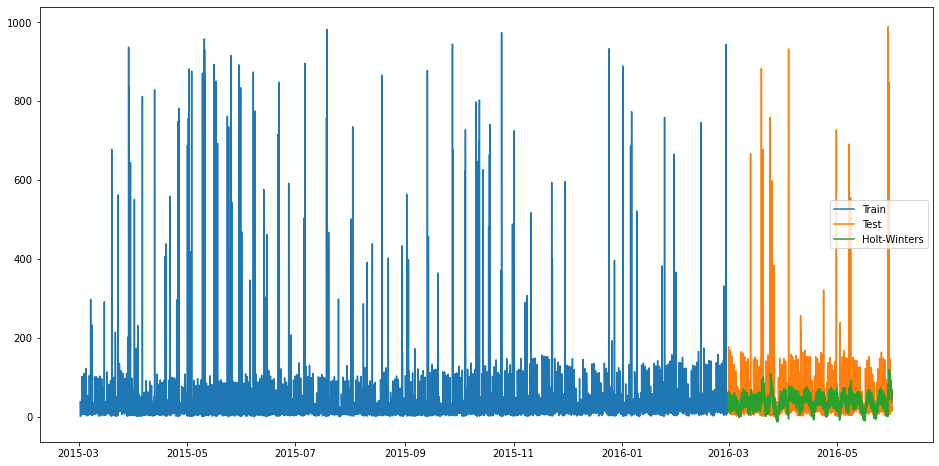

In [54]:
actual_values = hourly_mean_test['Valor']
df_train_history = [x for x in hourly_mean['Valor']]
predictions = list()
for i in range(len(actual_values)):
    model_fit = ExponentialSmoothing(df_train_history, trend='add', seasonal='add', seasonal_periods=6).fit()
    predictions.append(model_fit.predict(len(df_train_history),len(df_train_history)))
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean['datetime'], hourly_mean['Valor'], label='Train')
plt.plot(hourly_mean_test['datetime'],hourly_mean_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Holt-Winters')
plt.legend(loc='best')
plt.show()

In [55]:
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

65.4441899451686


## Agora com a base transformada (log)

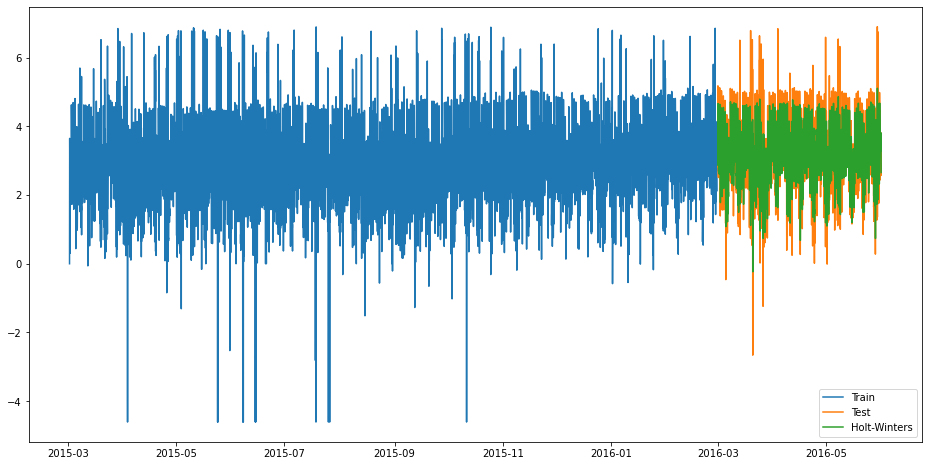

In [60]:
actual_values = hourly_mean_log_test['Valor']
df_train_history = [x for x in hourly_mean_log['Valor']]
predictions = list()
for i in range(len(actual_values)):
    model_fit = ExponentialSmoothing(df_train_history, trend='add', seasonal='add', seasonal_periods=6).fit()
    predictions.append(model_fit.predict(len(df_train_history),len(df_train_history)))
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_log_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean_log['datetime'], hourly_mean_log['Valor'], label='Train')
plt.plot(hourly_mean_log_test['datetime'],hourly_mean_log_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Holt-Winters')
plt.legend(loc='best')
plt.show()

In [61]:
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

74.11616008303896


## Agora com a base transformada (return log)

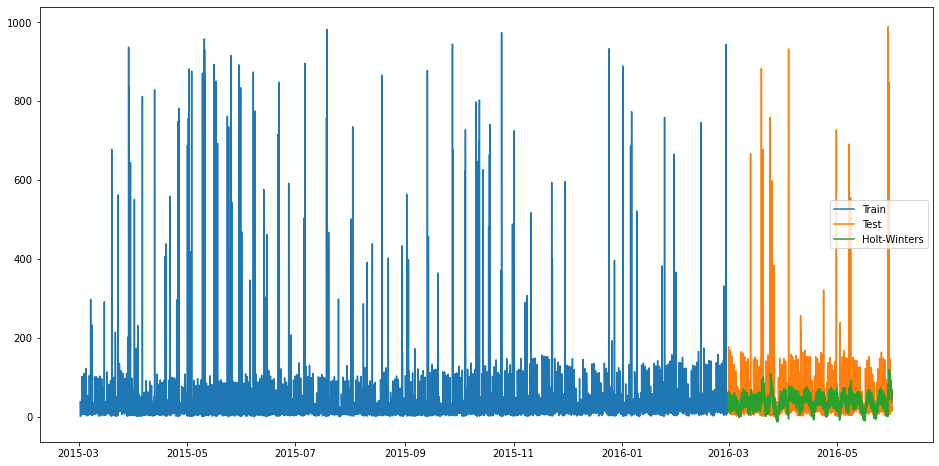

In [62]:
actual_values = hourly_mean_return_log_test['Valor']
df_train_history = [x for x in hourly_mean_return_log['Valor']]
predictions = list()
for i in range(len(actual_values)):
    model_fit = ExponentialSmoothing(df_train_history, trend='add', seasonal='add', seasonal_periods=6).fit()
    predictions.append(model_fit.predict(len(df_train_history),len(df_train_history)))
    df_train_history.append(actual_values[i])
df_predict = hourly_mean_return_log_test.copy()
df_predict['Valor'] = predictions
plt.figure(figsize=(16,8))
plt.plot(hourly_mean_return_log['datetime'], hourly_mean_return_log['Valor'], label='Train')
plt.plot(hourly_mean_return_log_test['datetime'],hourly_mean_return_log_test['Valor'], label='Test')
plt.plot(df_predict['datetime'],df_predict['Valor'], label='Holt-Winters')
plt.legend(loc='best')
plt.show()

In [63]:
rms = sqrt(mean_squared_error(hourly_mean_test['Valor'], df_predict['Valor']))
print(rms)

65.4441899451686
